In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

import prophet

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential

import warnings
warnings.filterwarnings("ignore")
import datetime
import math

2024-04-20 09:35:51.641300: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-20 09:35:51.641441: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-20 09:35:51.793600: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### EDA

In [2]:
# Loading Dataset
df = pd.read_csv("/kaggle/input/aapl-time-series/AAPL.csv", index_col=0)
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2015-05-27 00:00:00+00:00,132.045,132.260,130.05,130.34,45833246,121.682558,121.880685,119.844118,120.111360,45833246,0.0,1.0
1,AAPL,2015-05-28 00:00:00+00:00,131.780,131.950,131.10,131.86,30733309,121.438354,121.595013,120.811718,121.512076,30733309,0.0,1.0
2,AAPL,2015-05-29 00:00:00+00:00,130.280,131.450,129.90,131.23,50884452,120.056069,121.134251,119.705890,120.931516,50884452,0.0,1.0
3,AAPL,2015-06-01 00:00:00+00:00,130.535,131.390,130.05,131.20,32112797,120.291057,121.078960,119.844118,120.903870,32112797,0.0,1.0
4,AAPL,2015-06-02 00:00:00+00:00,129.960,130.655,129.32,129.86,33667627,119.761181,120.401640,119.171406,119.669029,33667627,0.0,1.0


In [3]:
# Checking Dtypes of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1258 entries, 0 to 1257
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   symbol       1258 non-null   object 
 1   date         1258 non-null   object 
 2   close        1258 non-null   float64
 3   high         1258 non-null   float64
 4   low          1258 non-null   float64
 5   open         1258 non-null   float64
 6   volume       1258 non-null   int64  
 7   adjClose     1258 non-null   float64
 8   adjHigh      1258 non-null   float64
 9   adjLow       1258 non-null   float64
 10  adjOpen      1258 non-null   float64
 11  adjVolume    1258 non-null   int64  
 12  divCash      1258 non-null   float64
 13  splitFactor  1258 non-null   float64
dtypes: float64(10), int64(2), object(2)
memory usage: 147.4+ KB


In [4]:
df.size

17612

In [5]:
df.shape

(1258, 14)

In [6]:
# Checking for NAN values
df.isnull().sum()

symbol         0
date           0
close          0
high           0
low            0
open           0
volume         0
adjClose       0
adjHigh        0
adjLow         0
adjOpen        0
adjVolume      0
divCash        0
splitFactor    0
dtype: int64

In [7]:
df.symbol.value_counts()

symbol
AAPL    1258
Name: count, dtype: int64

In [8]:
df.rename(columns={"date": "Date", "close": "Value"}, inplace=True)
df.head()

,symbol,Date,Value,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2015-05-27 00:00:00+00:00,132.045,132.260,130.05,130.34,45833246,121.682558,121.880685,119.844118,120.111360,45833246,0.0,1.0
1,AAPL,2015-05-28 00:00:00+00:00,131.780,131.950,131.10,131.86,30733309,121.438354,121.595013,120.811718,121.512076,30733309,0.0,1.0
2,AAPL,2015-05-29 00:00:00+00:00,130.280,131.450,129.90,131.23,50884452,120.056069,121.134251,119.705890,120.931516,50884452,0.0,1.0
3,AAPL,2015-06-01 00:00:00+00:00,130.535,131.390,130.05,131.20,32112797,120.291057,121.078960,119.844118,120.903870,32112797,0.0,1.0
4,AAPL,2015-06-02 00:00:00+00:00,129.960,130.655,129.32,129.86,33667627,119.761181,120.401640,119.171406,119.669029,33667627,0.0,1.0


In [9]:
df_new = df[["Value"]]
df_new.head()

,Value
0,132.045
1,131.780
2,130.280
3,130.535
4,129.960


In [10]:
df_new["Date"] = pd.to_datetime(pd.to_datetime(df["Date"]).dt.date)
df_new.head()

,Value,Date
0,132.045,2015-05-27
1,131.780,2015-05-28
2,130.280,2015-05-29
3,130.535,2015-06-01
4,129.960,2015-06-02


In [11]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1258 entries, 0 to 1257
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Value   1258 non-null   float64       
 1   Date    1258 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 29.5 KB


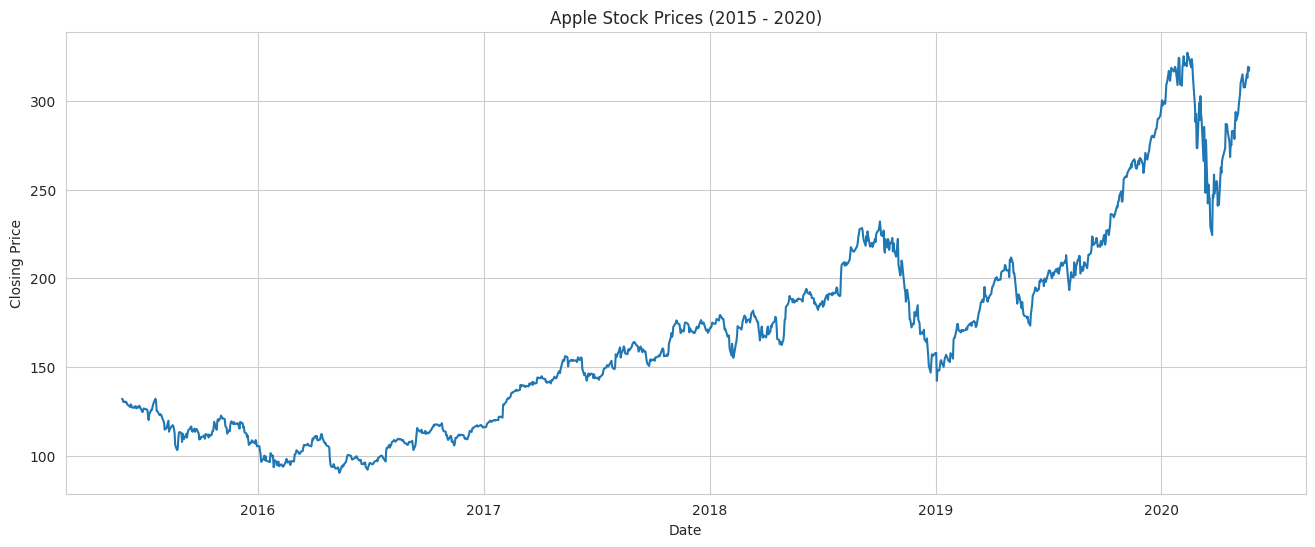

In [12]:
plt.figure(figsize=(16, 6))
sns.lineplot(data=df_new, x="Date", y="Value")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Apple Stock Prices (2015 - 2020)")
plt.show()

### Build Forecating Models

# Prophet  Model

In [13]:
# Renaming Date->ds and Value->y as Prophet expects the column names to be.
df_new_ = df_new.rename(mapper={"Date": "ds", "Value": "y"}, axis="columns")
df_new_.head()

,y,ds
0,132.045,2015-05-27
1,131.780,2015-05-28
2,130.280,2015-05-29
3,130.535,2015-06-01
4,129.960,2015-06-02


In [14]:
op = prophet.Prophet()
op.fit(df_new_)

09:36:04 - cmdstanpy - INFO - Chain [1] start processing
09:36:04 - cmdstanpy - INFO - Chain [1] done processing


In [15]:
forecast = op.make_future_dataframe(periods=365)
forecast = op.predict(forecast)

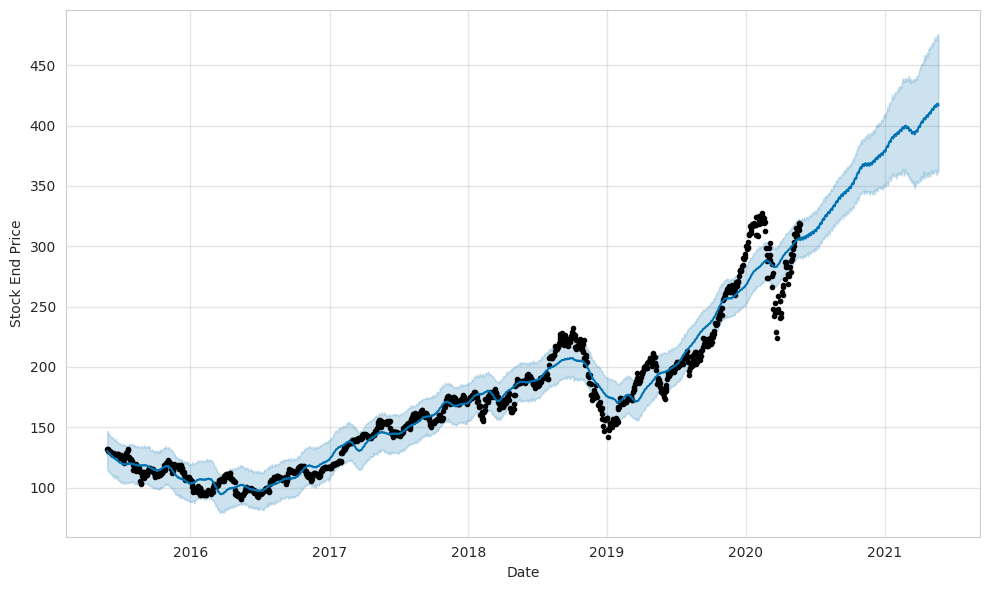

In [16]:
op.plot(forecast, xlabel="Date", ylabel="Stock End Price")
plt.show()

# ARIMA Model

In [17]:
df_new.shape

(1258, 2)

In [18]:
# Splitting Data into train and test set
X_train = df_new[:1000]
X_test = df_new[1000:]

print("X_train Shape", X_train.shape)
print("X_test Shape", X_test.shape)

X_train Shape (1000, 2)
X_test Shape (258, 2)


In [19]:
# Setting Date column as index of DataFrame
X_train = X_train[["Date", "Value"]]
X_test = X_test[["Date", "Value"]]

X_train.set_index("Date", inplace=True)
X_test.set_index("Date", inplace=True)

In [20]:
# Forecasting 9 months
index_9_months = pd.date_range(X_test.index[-1], freq="MS", periods=9)
index_9_months

DatetimeIndex(['2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01',
               '2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01',
               '2021-02-01'],
              dtype='datetime64[ns]', freq='MS')

# Performing ADF test

The Augmented Dickey-Fuller (ADF) test is a statistical test used to identify if a time series is stationary or not.

In [21]:
# P = 0.05
def define_d(data):
    X_train = adfuller(data, autolag="AIC")
    adf = X_train[0]
    pvalue = X_train[1]
    critical_value = X_train[4]["5%"]
    labels = [
        "ADF Test Statistic",
        "p-value",
        "#Lags Used",
        "Number of Observations",
        "Critical Value",
    ]
    for value, label in zip(X_train, labels):
        print(label + " : " + str(value))

    if pvalue < 0.05:
        print("** Data Is Stationary **")
    else:
        print("** Indicating It Is Non-Stationary **")


define_d(X_train)

ADF Test Statistic : -0.8012872716747915
p-value : 0.8187436488375897
#Lags Used : 8
Number of Observations : 991
Critical Value : {'1%': -3.4369658620871286, '5%': -2.8644609013346485, '10%': -2.56832523159495}
** Indicating It Is Non-Stationary **


### Performing differencing to make it stationary

In [22]:
data_diff = X_train.diff()
data_diff.dropna(inplace=True)
define_d(data_diff)

ADF Test Statistic : -10.586179658609991
p-value : 6.707844077679182e-19
#Lags Used : 7
Number of Observations : 991
Critical Value : {'1%': -3.4369658620871286, '5%': -2.8644609013346485, '10%': -2.56832523159495}
** Data Is Stationary **


### Define p and q using PACF and ACF plot

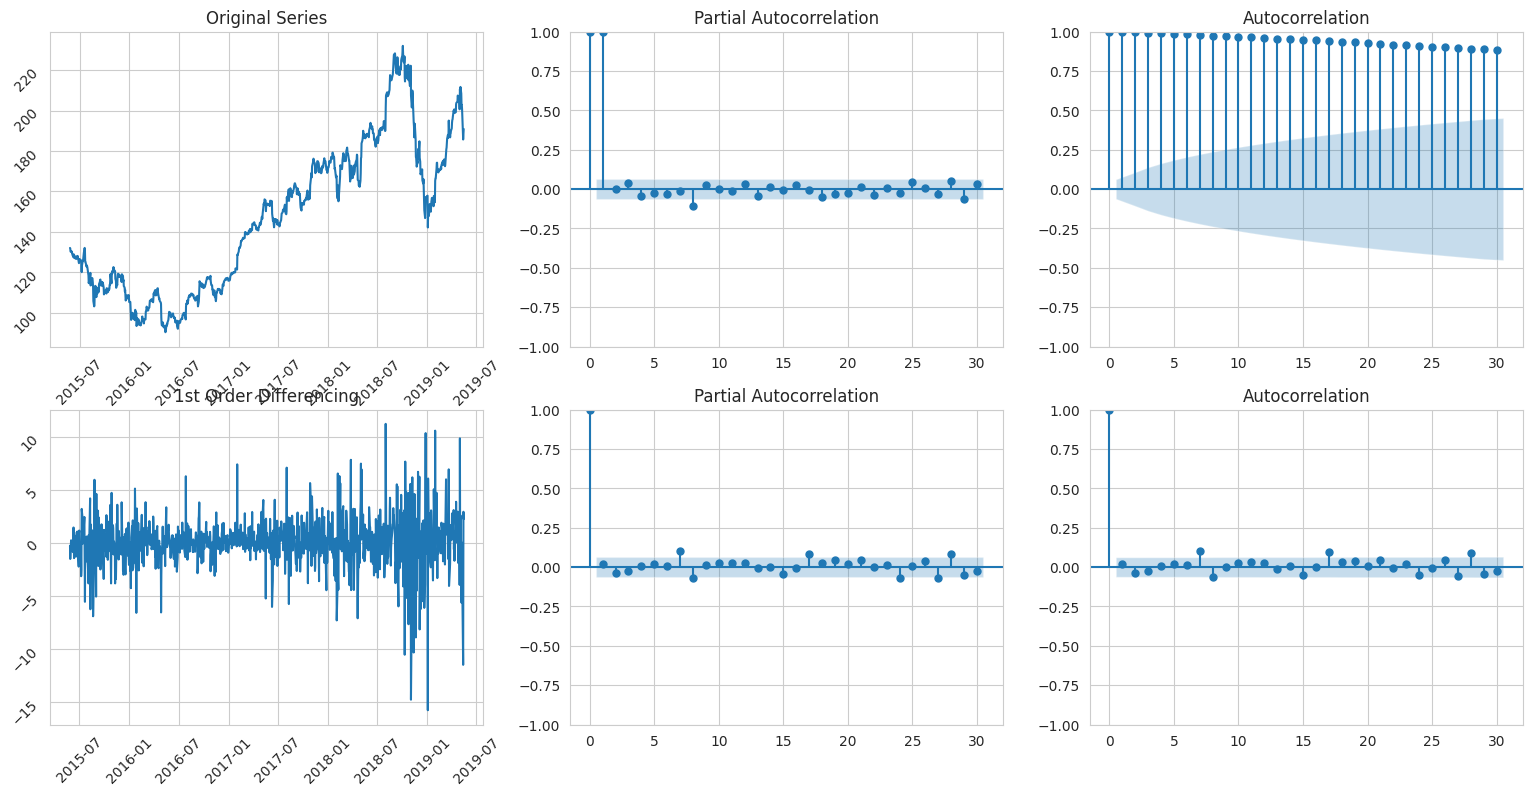

In [23]:
# Original Series
fig, axes = plt.subplots(2, 3)
fig.set_figheight(9)
fig.set_figwidth(19)
axes[0, 0].plot(X_train)
axes[0, 0].tick_params(labelrotation=45)
axes[0, 0].set_title("Original Series")
plot_pacf(X_train, ax=axes[0, 1])
plot_acf(X_train, ax=axes[0, 2])

# 1st Differencing
axes[1, 0].plot(X_train.diff())
axes[1, 0].set_title("1st Order Differencing")
axes[1, 0].tick_params(labelrotation=45)
plot_pacf(X_train.diff().dropna(), ax=axes[1, 1])
plot_acf(X_train.diff().dropna(), ax=axes[1, 2])

plt.show();

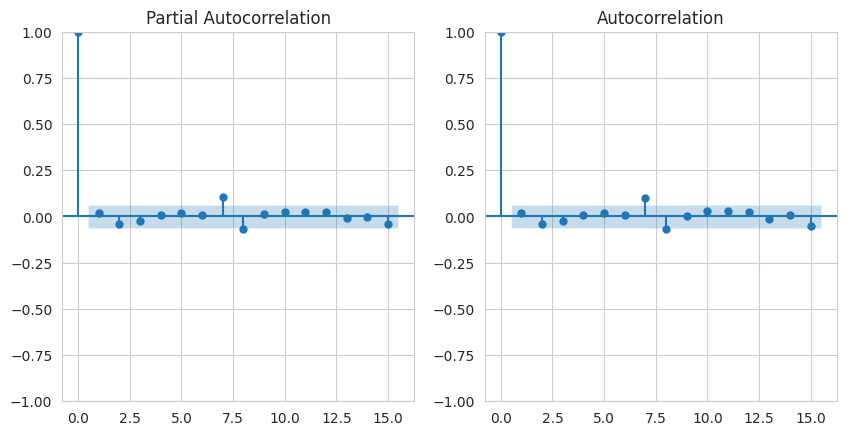

In [24]:
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(10)
plot_pacf(X_train.diff().dropna(), lags=15, ax=ax[0])
plot_acf(X_train.diff().dropna(), lags=15, ax=ax[1])
plt.show()

In [25]:
price_validate = df_new["Value"][1000:]
price_validate

1000    190.08
1001    189.00
1002    183.09
1003    186.60
1004    182.78
         ...  
1253    314.96
1254    313.14
1255    319.23
1256    316.85
1257    318.89
Name: Value, Length: 258, dtype: float64

###  Calculating error

In [26]:
def forecast_accuracy(forecast, actual):
    mape = (np.mean(np.abs(forecast - actual) / np.abs(actual)) * 100).round(2)
    rmse = np.sqrt(((forecast - actual) ** 2).mean())
    return {"Mean Absolute Percentage Error (%)": mape, "Root Mean Squared Error": rmse}

### Model 1

In [27]:
model = ARIMA(X_train)
model = model.fit()
print(model.summary())

fc = model.forecast(258)
forecast_accuracy(fc, price_validate.values)

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                 1000
Model:                          ARIMA   Log Likelihood               -5021.697
Date:                Sat, 20 Apr 2024   AIC                          10047.395
Time:                        09:36:10   BIC                          10057.210
Sample:                             0   HQIC                         10051.125
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        146.3985      1.231    118.912      0.000     143.985     148.811
sigma2      1347.0718     88.928     15.148      0.000    1172.776    1521.368
Ljung-Box (L1) (Q):                 997.04   Jarque-

{'Mean Absolute Percentage Error (%)': 39.67,
 'Root Mean Squared Error': 112.88859873181204}

### Model 2

In [28]:
model = ARIMA(X_train, order=(1, 0, 1))
model = model.fit()
print(model.summary())

fc = model.forecast(258)
forecast_accuracy(fc, price_validate.values)

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                 1000
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -2303.509
Date:                Sat, 20 Apr 2024   AIC                           4615.019
Time:                        09:36:10   BIC                           4634.650
Sample:                             0   HQIC                          4622.480
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        146.3986     55.446      2.640      0.008      37.726     255.071
ar.L1          0.9984      0.002    504.168      0.000       0.995       1.002
ma.L1          0.0193      0.022      0.864      0.3

{'Mean Absolute Percentage Error (%)': 24.96,
 'Root Mean Squared Error': 82.74550607394875}

### Model 3

In [29]:
model = ARIMA(X_train, order=(1, 1, 1))
model = model.fit()
print(model.summary())

fc = model.forecast(258)
forecast_accuracy(fc, price_validate.values)

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                 1000
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2297.919
Date:                Sat, 20 Apr 2024   AIC                           4601.837
Time:                        09:36:10   BIC                           4616.558
Sample:                             0   HQIC                          4607.432
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8601      0.121     -7.104      0.000      -1.097      -0.623
ma.L1          0.8861      0.109      8.136      0.000       0.673       1.100
sigma2         5.8273      0.133     43.798      0.0

{'Mean Absolute Percentage Error (%)': 21.96,
 'Root Mean Squared Error': 73.9815546507975}

Plotting Residuals

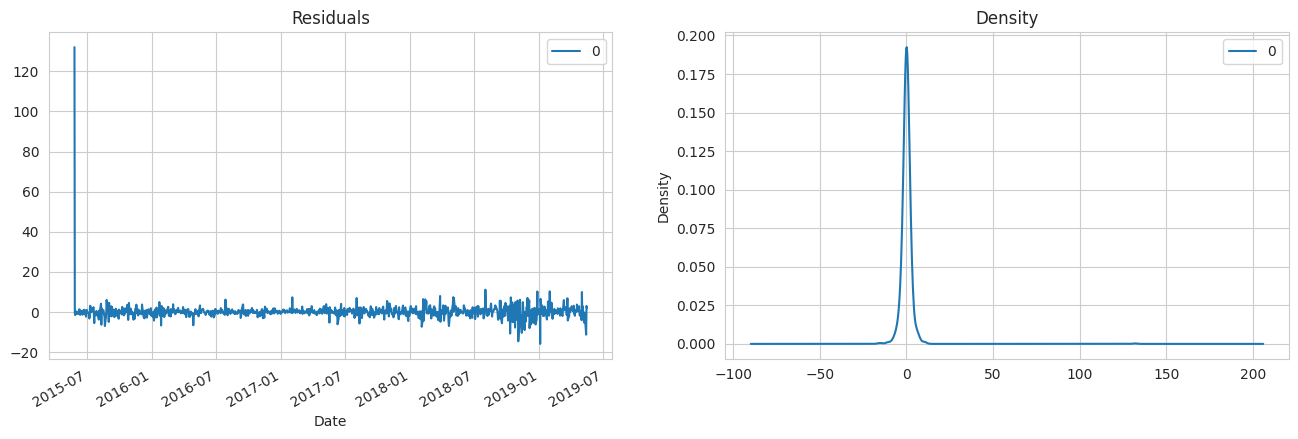

In [30]:
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(16)
residuals = pd.DataFrame(model.resid)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind="kde", title="Density", ax=ax[1])
plt.show()

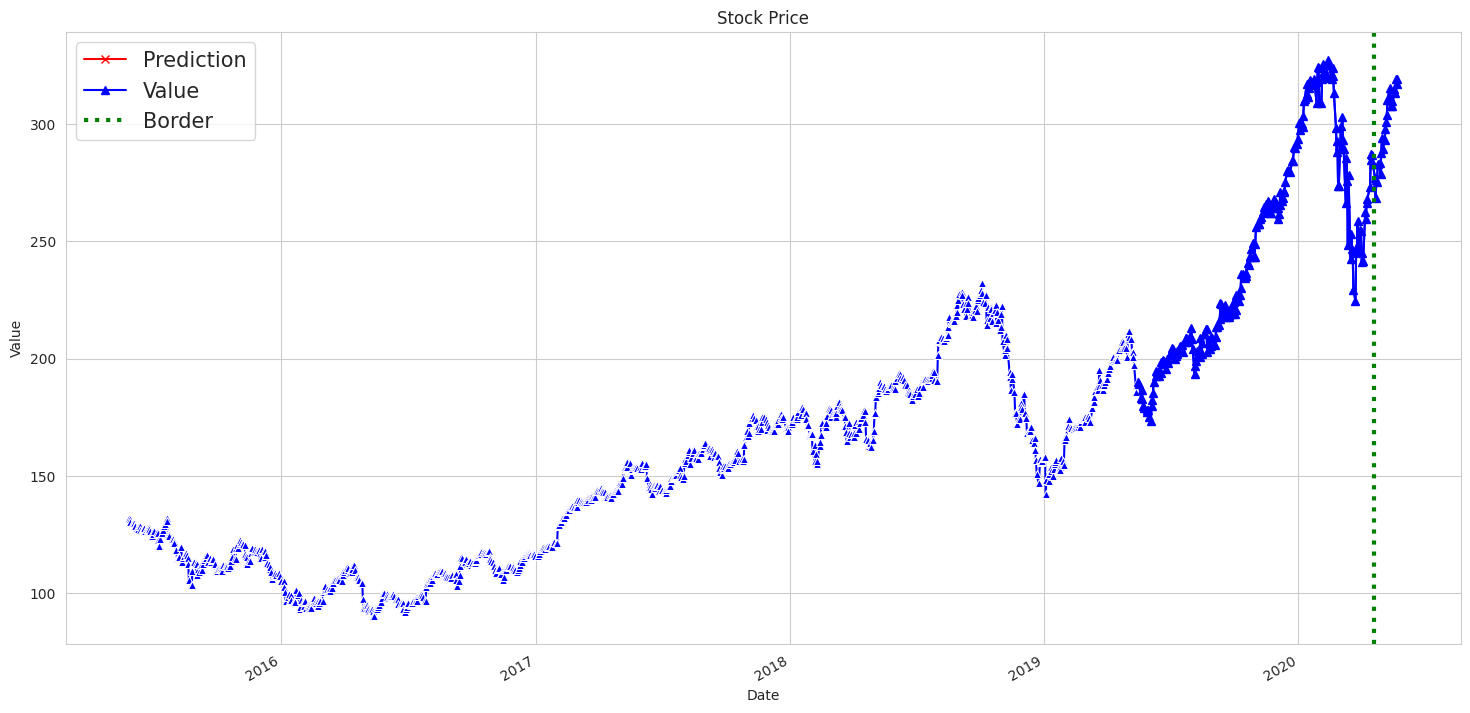

In [31]:
# Forecasting for last 9 months
price_forecast = model.forecast(9)
price_forecast = pd.Series(price_forecast, index=index_9_months)
price_forecast = price_forecast.rename("Prediction")

fig, ax = plt.subplots(figsize=(18, 9))
sns.lineplot(x="Date", y="Value", data=df_new, color="blue", marker="^")
price_forecast.plot(ax=ax, c="red", marker="x", label="Prediction")
X_test.plot(ax=ax, c="blue", marker="^")
plt.title("Stock Price")
ax.axvline(x=18370, ls=":", linewidth=3, c="green", label="Border")
plt.legend(loc=0, fontsize=15)
plt.show()

In [32]:
# Printing Predicted Price
df = pd.DataFrame({"Predictions": model.forecast(9)})
df["date"] = index_9_months
df.set_index("date")

,Predictions
date,
2020-06-01,190.823482
2020-07-01,190.906498
2020-08-01,190.835095
2020-09-01,190.896509
2020-10-01,190.843687
2020-11-01,190.889119
2020-12-01,190.850043
2021-01-01,190.883652
2021-02-01,190.854745


### LSTM Model

In [33]:
x_train, y_train = X_train.index, X_train.Value
x_test, y_test = X_test.index, X_test.Value

print(x_train.shape), print(x_test.shape)

(1000,)
(258,)


(None, None)

In [34]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(loss="mean_squared_error", optimizer="adam")

In [35]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=64,
    verbose=1,
)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 22858.7988 - val_loss: 64510.7578
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 22476.4141 - val_loss: 64139.0352
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 22259.5371 - val_loss: 63035.3398
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 21696.5117 - val_loss: 61521.1289
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 20813.5938 - val_loss: 60289.1484
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 20251.3574 - val_loss: 59510.1172
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 19554.9980 - val_loss: 58983.8867
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 19807.1953 - val_loss: 58537.9102
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 19148.4590 - val_loss: 58130.0391
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 19091.7480 - val_loss: 57744.6016
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 18974.03

In [37]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [38]:
print(f"RMSE {math.sqrt(mean_squared_error(y_train, train_predict))}")

RMSE 87.89448046446557


In [39]:
train_predict[:10]

array([[66.53242],
       [66.53241],
       [66.53242],
       [66.53242],
       [66.53242],
       [66.53242],
       [66.53242],
       [66.53242],
       [66.53242],
       [66.53242]], dtype=float32)